In [1]:
import numpy as np
import pandas as pd 
import scanpy as sc
import utils
import mrf
import os 
import random 
import imp
import mrf
import time

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_17870/3164274336.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [12]:
imp.reload(mrf)

<module 'mrf' from '/home/qinxianhan/project/spatial/Hidden_Markov_Random_Field/src/mrf.py'>

In [3]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))
import seaborn as sns

In [4]:
adata = sc.read_visium('../../dataset/goldStandard')
adata.var_names_make_unique()
adata = utils.data_preprocess(adata)

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
from sklearn import mixture 
gmm = mixture.GaussianMixture(n_components=2)

In [6]:
coord = np.array(adata.obs.iloc[:,1:3])
target_list =['CAMK2N1', 'PCP4', 'NEFM', 'NEFH', 'B3GALT2']
target_gene =target_list[1]

In [13]:
beta =5
labels_list= mrf.mrf_process(adata, gene_id=target_gene, beta = beta,max_iteration=5e4)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/qinxianhan/project/spatial/Hidden_Markov_Random_Field/src/mrf.py:172: RuntimeWarning: invalid value encountered in divide
  
100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


In [14]:
exp = adata[:,target_gene].X.toarray()
gmm = mixture.GaussianMixture(n_components=2)
gmm.fit(exp)
gmm_labels = gmm.predict(exp)

In [15]:
gmm.covariances_

array([[[1.00000000e-06]],

       [[3.54804567e-01]]])

In [16]:
from datetime import date
today = date.today()
today = today.strftime("%m_%d")
today

'10_31'

In [23]:
def label_reverse(labels_list):
    labels_list = np.array(labels_list)
    labels_list[labels_list==0]=2
    labels_list[labels_list==1]=0
    labels_list[labels_list==2]=1
    return labels_list

In [86]:
labels_list = label_reverse(labels_list)

In [17]:
output_dir = '../output/{}/'.format(today)
os.path.exists(output_dir) or os.makedirs(output_dir)

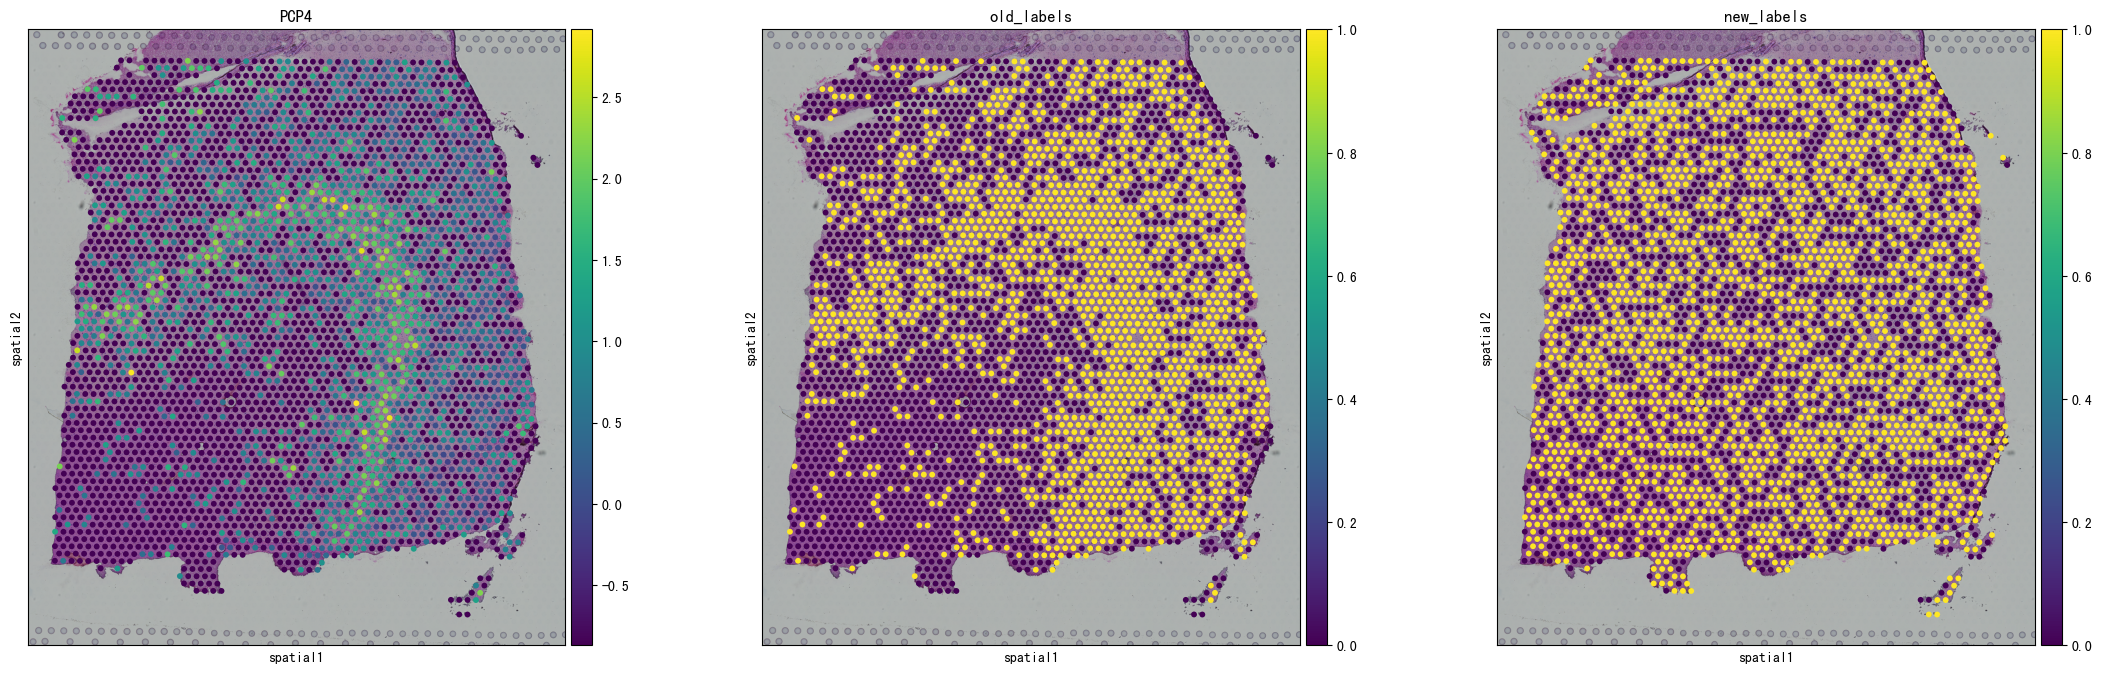

In [18]:
adata.obs['old_labels'] = gmm_labels
adata.obs['new_labels'] = labels_list
sc.pl.spatial(adata, color=[target_gene,'old_labels','new_labels'])

In [61]:
np.var([1,1,1,1,1])

0.0